# Benchmarking FRNN Performance

Explore the techniques described in [this paper](https://reader.elsevier.com/reader/sd/pii/0020019077900709?token=E45C0E1870EA26C21C1F149B6090CE4630A51269D324BE1206B7BF2764FB48B2DDC93F4B86FBFBD8CBDED63B15BBC6DA&originRegion=us-east-1&originCreation=20210428165528).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
from time import time as tt
import importlib

# External imports
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import torch
# from torch_geometric.data import DataLoader

from itertools import chain
from random import shuffle, sample
from scipy.optimize import root_scalar as root

from torch.nn import Linear
import torch.nn.functional as F
import trackml.dataset
from itertools import permutations
import itertools
from sklearn import metrics, decomposition
from torch.utils.checkpoint import checkpoint

import faiss

device = "cuda" if torch.cuda.is_available() else "cpu"

exatrkx_pipeline = '/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/TrackML_Example'
sys.path.append(exatrkx_pipeline)

from LightningModules.Embedding.utils import graph_intersection, build_edges

%matplotlib inline

# Load Model and Dataset

Load the lightning module and setup the model to get the dataset

CHANGE THE EXATRKX PIPELINE LOCATION TO YOUR PARTICULAR LOCATION

In [ ]:
exatrkx_pipeline = '/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/TrackML_Example'
sys.path.append(exatrkx_pipeline)

[autoreload of torch.serialization failed: Traceback (most recent call last):
  File "/global/homes/d/danieltm/.conda/envs/frnn-test/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/global/homes/d/danieltm/.conda/envs/frnn-test/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/global/homes/d/danieltm/.conda/envs/frnn-test/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/global/homes/d/danieltm/.conda/envs/frnn-test/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 848, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/global/homes/d/danieltm/.conda/envs/frnn-test/lib/python3.8/site-p

In [ ]:
from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
from LightningModules.Embedding.utils import graph_intersection, build_edges

## Load model for inference (if data not already saved)

CHANGE THE CHECKPOINT DIRECTORY TO YOUR PARTICULAR LOCATION

In [4]:
chkpt_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/lightning_checkpoints/CodaEmbeddingStudy/pbn07koj"
chkpt_file = "last.ckpt"
chkpt_path = os.path.join(chkpt_dir, chkpt_file)

In [5]:
model = LayerlessEmbedding.load_from_checkpoint(chkpt_path)

In [6]:
model.hparams["train_split"] = [100,10,10]

In [7]:
model.setup(stage="fit")

In [8]:
model = model.to(device)

# FRNN Testing

## Prepare and save input data

In [82]:
batch = model.trainset[0].to(device)
with torch.no_grad():
    spatial = model(torch.cat([batch.cell_data, batch.x], axis=-1))

In [87]:
batch.spatial = spatial
torch.save(batch, "example_event.pkl")

## Load saved input data

In [3]:
batch = torch.load("example_event.pkl")

In [4]:
spatial = batch.spatial

## Run FRNN algorithm

In [5]:
import frnn

In [22]:
r = 1.7
K = 500

In [23]:
%%time
# first time there is no cached grid
dists, idxs, nn, grid = frnn.frnn_grid_points(
    points1=spatial.unsqueeze(0), points2=spatial.unsqueeze(0), lengths1=None, lengths2=None, K=K, r=r, grid=None, return_nn=False, return_sorted=True
)

CPU times: user 0 ns, sys: 3.66 ms, total: 3.66 ms
Wall time: 3.22 ms


In [25]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

dists, idxs, nn, grid = frnn.frnn_grid_points(
    points1=spatial.unsqueeze(0), points2=spatial.unsqueeze(0), lengths1=None, lengths2=None, K=K, r=r, grid=grid, return_nn=False, return_sorted=True
)

# Remove the unneccessary batch dimension
idxs = idxs.squeeze()

ind = torch.Tensor.repeat(torch.arange(idxs.shape[0], device=device), (idxs.shape[1], 1), 1).T
positive_idxs = idxs >= 0
edge_list = torch.stack([ind[positive_idxs], idxs[positive_idxs]])

# Remove self-loops
e_spatial = edge_list[:, edge_list[0] != edge_list[1]]

torch.cuda.synchronize()
end.record()
time = start.elapsed_time(end)
print(f"Time taken: {time:.5}ms")

Time taken: 26.757ms


## Accuracy Performance

Find truth

In [26]:
e_bidir = torch.cat([batch.layerless_true_edges, batch.layerless_true_edges.flip(0)], axis=-1) 
e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir, using_weights=False)

In [27]:
t = e_bidir.shape[1]
tp = y_cluster.sum()
p = e_spatial.shape[1]

In [28]:
print(f'Efficiency: {tp / t}, Purity: {tp / p}')

Efficiency: 0.9626750946044922, Purity: 0.025947330519557


In [35]:
def get_metrics(e_spatial):
    
    e_bidir = torch.cat([batch.layerless_true_edges, batch.layerless_true_edges.flip(0)], axis=-1) 
    e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir, using_weights=False)
    
    t = e_bidir.shape[1]
    tp = y_cluster.sum()
    p = e_spatial.shape[1]
    
    eff, pur = tp/t, tp/p
    return eff, pur

# Scan over R, K

In [81]:
r_list = np.arange(1, 2.2, 0.1)
K_list = np.arange(10, 1000, 100)

In [ ]:
timings = []
effs = []
purs = []

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

for r in r_list:
    for K in K_list:
        torch.cuda.synchronize()
#         start.record()
#         torch.cuda.synchronize()
        tic = tt()
        dists, idxs, nn, grid = frnn.frnn_grid_points(
            points1=spatial.unsqueeze(0), points2=spatial.unsqueeze(0), lengths1=None, lengths2=None, K=K, r=r, grid=grid, return_nn=False, return_sorted=True
        )

        # Remove the unneccessary batch dimension
        idxs = idxs.squeeze()

        ind = torch.Tensor.repeat(torch.arange(idxs.shape[0], device=device), (idxs.shape[1], 1), 1).T
        positive_idxs = idxs >= 0
        edge_list = torch.stack([ind[positive_idxs], idxs[positive_idxs]])

        # Remove self-loops
        e_spatial = edge_list[:, edge_list[0] != edge_list[1]]

        torch.cuda.synchronize()
#         end.record()
#         time = start.elapsed_time(end)
        time = tt() - tic
        timings.append(time)
        
        print(f"Time taken: {time:.5}s for r={r}, K={K}")
        
        eff, pur = get_metrics(e_spatial)
        effs.append(eff)
        purs.append(pur)
        torch.cuda.synchronize()

In [83]:
timings = np.array(timings).reshape((13, 10))
effs = np.array(effs).reshape((13, 10))
purs = np.array(purs).reshape((13, 10))

[Text(69.0, 0.5, 'r (radius)'),
 Text(0.5, 69.0, 'k (num neighbors)'),
 Text(0.5, 1.0, 'Timings')]

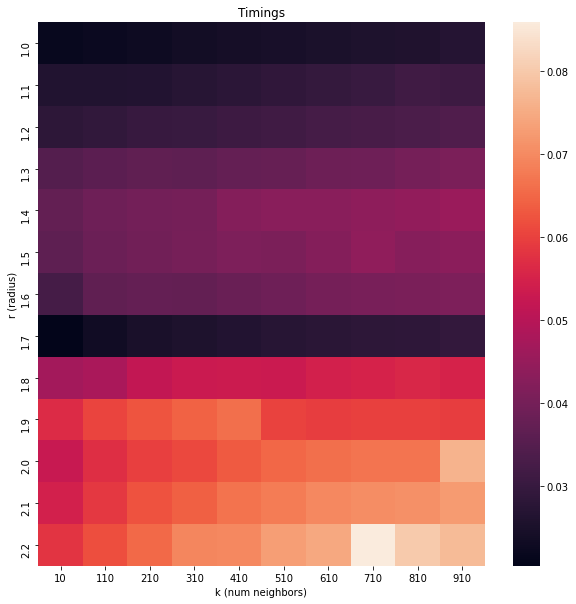

In [88]:
plt.figure(figsize=(10,10))
ax =sns.heatmap(timings, xticklabels = K_list, yticklabels = np.around(r_list, 1))
ax.set(ylabel='r (radius)', xlabel='k (num neighbors)', title="Timings")

[Text(69.0, 0.5, 'r (radius)'),
 Text(0.5, 69.0, 'k (num neighbors)'),
 Text(0.5, 1.0, 'Efficiencies')]

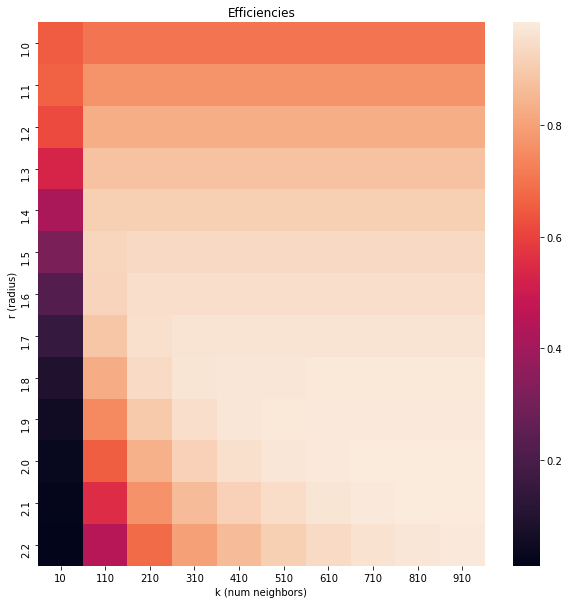

In [89]:
plt.figure(figsize=(10,10))
ax =sns.heatmap(effs, xticklabels = K_list, yticklabels = np.around(r_list, 1))
ax.set(ylabel='r (radius)', xlabel='k (num neighbors)', title="Efficiencies")

[Text(69.0, 0.5, 'r (radius)'),
 Text(0.5, 69.0, 'k (num neighbors)'),
 Text(0.5, 1.0, 'Purities')]

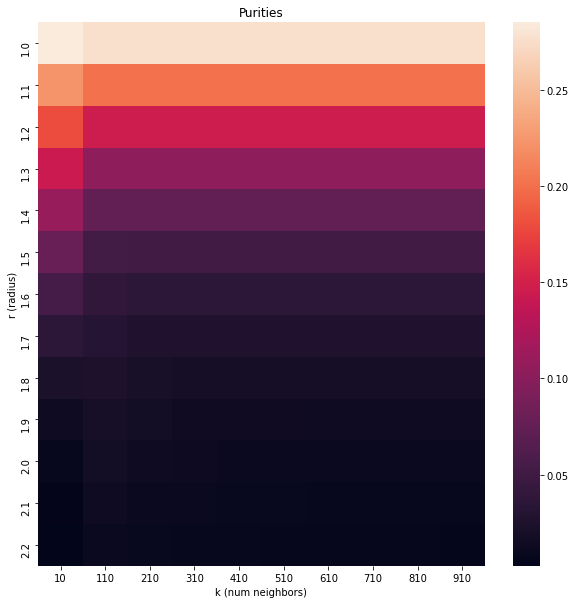

In [90]:
plt.figure(figsize=(10,10))
ax =sns.heatmap(purs, xticklabels = K_list, yticklabels = np.around(r_list, 1))
ax.set(ylabel='r (radius)', xlabel='k (num neighbors)', title="Purities")